# Import libraries

In [73]:
from google.colab import drive
# Mount drive from Google
drive.mount('/content/gdrive')

import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F
from random import shuffle
import time
import pickle

if not torch.cuda.is_available():
    raise SystemError("GPU device not found, selection Runtime -> Change runtime type")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Define parameters

In [74]:
# Define dictionary of parameters and hyper parametes

args = {
    'bs': 128,
    'num_tasks': 5,
    'dataset': 'MNIST',
    'num_classes': 10,
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 50,
    'lr_classifier':0.001,
    'lr_vae':0.002,
    'epochs_classifier':2,
    'epochs_vae':15,
    'latent_dim':100,
         }

# Main path
root_path = '/content/gdrive/MyDrive/PhD_Data_Science/courses_and_seminars/Deep generative view on continual learning/assignment/'
%cd $root_path

/content/gdrive/.shortcut-targets-by-id/1j-L1G8LcOgzfkI4a-l0lFxnMvIE8uMpN/PhD_Data_Science/courses_and_seminars/Deep generative view on continual learning/assignment


# Define classes and functions

In [75]:
def get_dataset(dataroot, dataset):
    if dataset == 'MNIST':
        mean, std = (0.1307), (0.3081)
    elif dataset == 'CIFAR10':
        mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std)])

    train_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform
    )

    val_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )

    return train_dataset, val_dataset

def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        split_dataset[e] = Subset(dataset, np.where(task_indices)[0])
    return split_dataset

def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array

def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.show()

def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=f"Task {e}")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc

def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt

def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt

class Encoder(torch.nn.Module):
    def __init__(self, img_shape, latent_dim):
        super(Encoder, self).__init__()
        self.img_shape = img_shape
        self.latent_dim = latent_dim

        self.model = torch.nn.Sequential(
            torch.nn.Linear(int(np.prod(img_shape)), 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU()
        )

        self.mu = torch.nn.Linear(128, latent_dim)
        self.logvar = torch.nn.Linear(128, latent_dim)

    def forward(self, img):
        x = self.model(img.view(img.size(0), -1))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

class Decoder(torch.nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Decoder, self).__init__()
        self.img_shape = img_shape

        self.model = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, int(np.prod(img_shape))),
            torch.nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

class VAE(torch.nn.Module):
    def __init__(self, img_shape, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(img_shape, latent_dim)
        self.decoder = Decoder(latent_dim, img_shape)

    def forward(self, img):
        mu, logvar = self.encoder(img)
        z = self.reparameterize(mu, logvar)
        recon_img = self.decoder(z)
        return recon_img, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def loss_function(self, recon_img, img, mu, logvar):
        recon_loss = F.mse_loss(recon_img, img, reduction='mean')
        kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kld_loss

class Agent:
    def __init__(self, args, train_datasets, val_datasets):
        self.args = args
        self.model = MLP(self.args)
        if torch.cuda.is_available():
            self.model.cuda()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr_classifier'])
        self.criterion = torch.nn.CrossEntropyLoss()
        self.reset_acc()
        self.train_datasets = train_datasets
        self.val_datasets = val_datasets

        self.latent_dim = args['latent_dim']
        self.img_shape = (args['n_channels'], args['in_size'], args['in_size'])

        self.vae = VAE(self.img_shape, self.latent_dim)

        if torch.cuda.is_available():
            self.vae.cuda()

    def reset_acc(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}

    def initialize_vae(self):
        self.vae = VAE(self.img_shape, self.latent_dim)
        if torch.cuda.is_available():
            self.vae.cuda()

    def train_vae(self, task_loader, task):
        optimizer = torch.optim.Adam(self.vae.parameters(), lr=self.args['lr_vae'])

        for epoch in range(self.args['epochs_vae']):
            for i, (imgs, _) in enumerate(task_loader):
                imgs = imgs.cuda() if torch.cuda.is_available() else imgs

                optimizer.zero_grad()
                recon_imgs, mu, logvar = self.vae(imgs)
                loss = self.vae.loss_function(recon_imgs, imgs, mu, logvar)
                loss.backward()
                optimizer.step()

            print(f"Task {task} | Epoch {epoch} | VAE loss: {loss.item()}")

        visualize_generated_images(self, num_images=10)

    def replay_data(self, num_samples):
        z = torch.randn(num_samples, self.latent_dim)
        if torch.cuda.is_available():
            z = z.cuda()
        with torch.no_grad():
            gen_imgs = self.vae.decoder(z).detach()
            replay_labels = torch.argmax(self.model(gen_imgs), dim=1)
        return gen_imgs, replay_labels

    def train(self):
        replay_datasets = []
        replay_labels_list = []

        self.memory_usage = []
        self.computation_times = []

        for task, data in self.train_datasets.items():
            task_loader = DataLoader(data, batch_size=self.args['bs'], shuffle=True)

            start_time = time.time()

            for epoch in range(self.args['epochs_classifier']):
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in enumerate(task_loader):
                    if torch.cuda.is_available():
                        X, y = X.cuda(), y.cuda()

                    if replay_datasets:
                        replay_data = torch.cat(replay_datasets, dim=0)
                        replay_labels = torch.cat(replay_labels_list, dim=0)
                        replay_data = replay_data.to(X.device)
                        replay_labels = replay_labels.to(y.device)
                        X_replay = torch.cat([X, replay_data], dim=0)
                        y_replay = torch.cat([y, replay_labels], dim=0)
                        if torch.cuda.is_available():
                            X_replay, y_replay = X_replay.cuda(), y_replay.cuda()
                    else:
                        X_replay, y_replay = X, y

                    # Forward pass
                    output = self.model(X_replay)
                    loss = self.criterion(output, y_replay)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y_replay)
                    total += len(X_replay)

                    if e % 50 == 0:
                        self.validate()

                print(f"Task {task} | Epoch {epoch}: Loss {epoch_loss/(e+1):.3f} Acc: {correct/total:.3f}")

            self.validate(end_of_epoch=True)
            self.initialize_vae()
            self.train_vae(task_loader, task)
            replay_data, replay_labels = self.replay_data(len(task_loader.dataset))
            replay_data = replay_data.to(next(self.model.parameters()).device)
            replay_labels = replay_labels.to(next(self.model.parameters()).device)
            replay_datasets.append(replay_data)
            replay_labels_list.append(replay_labels)
            end_time = time.time()
            self.computation_times.append(end_time - start_time)
            if torch.cuda.is_available():
                self.memory_usage.append(torch.cuda.memory_allocated())

        print("Memory usage (in bytes):", self.memory_usage)
        print("Computation times (in seconds):", self.computation_times)

    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.model.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=self.args['bs'], shuffle=True)
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                if torch.cuda.is_available():
                    X, y = X.cuda(), y.cuda()
                output = self.model(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
        self.model.train()

class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])

    def forward(self, input):
        x = input.flatten(start_dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def visualize_generated_images(agent, num_images):
    device = next(agent.model.parameters()).device
    z = torch.randn(num_images, agent.latent_dim, device=device)
    with torch.no_grad():
        gen_imgs = agent.vae.decoder(z).detach().to(device)
        predicted_labels = torch.argmax(agent.model(gen_imgs), dim=1)

    gen_imgs = gen_imgs.cpu().numpy().transpose(0, 2, 3, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(gen_imgs[i].squeeze(), cmap='gray')
        ax.set_title(f"Label: {predicted_labels[i].item()}")
        ax.axis('off')
    plt.show()


# Train VAE replay for CL


## Load and preprocess data

In [76]:
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)

In [77]:
class_split

{'0': [6, 1], '1': [2, 8], '2': [3, 4], '3': [0, 9], '4': [5, 7]}

## Fit VAE replay

Task 0 | Epoch 0: Loss 0.275 Acc: 0.942
Task 0 | Epoch 1: Loss 0.008 Acc: 0.997
Task 0 | Epoch 0 | VAE loss: 0.5101261138916016
Task 0 | Epoch 1 | VAE loss: 0.48619499802589417
Task 0 | Epoch 2 | VAE loss: 0.4726792573928833
Task 0 | Epoch 3 | VAE loss: 0.45850226283073425
Task 0 | Epoch 4 | VAE loss: 0.43160954117774963
Task 0 | Epoch 5 | VAE loss: 0.41543400287628174
Task 0 | Epoch 6 | VAE loss: 0.410155326128006
Task 0 | Epoch 7 | VAE loss: 0.44309109449386597
Task 0 | Epoch 8 | VAE loss: 0.3800046145915985
Task 0 | Epoch 9 | VAE loss: 0.41354864835739136
Task 0 | Epoch 10 | VAE loss: 0.414315402507782
Task 0 | Epoch 11 | VAE loss: 0.3867521286010742
Task 0 | Epoch 12 | VAE loss: 0.412331223487854
Task 0 | Epoch 13 | VAE loss: 0.3806111812591553
Task 0 | Epoch 14 | VAE loss: 0.3741268813610077


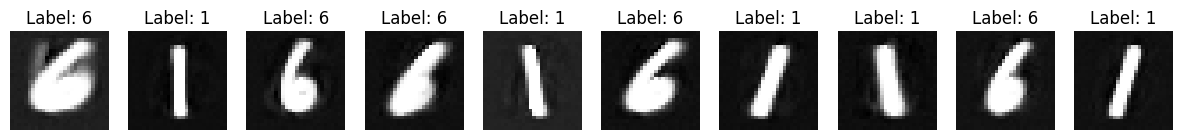

Task 1 | Epoch 0: Loss 0.061 Acc: 0.991
Task 1 | Epoch 1: Loss 0.010 Acc: 0.998
Task 1 | Epoch 0 | VAE loss: 0.6636753678321838
Task 1 | Epoch 1 | VAE loss: 0.6997694373130798
Task 1 | Epoch 2 | VAE loss: 0.6867409944534302
Task 1 | Epoch 3 | VAE loss: 0.7021036744117737
Task 1 | Epoch 4 | VAE loss: 0.6507587432861328
Task 1 | Epoch 5 | VAE loss: 0.7015174031257629
Task 1 | Epoch 6 | VAE loss: 0.711912989616394
Task 1 | Epoch 7 | VAE loss: 0.6388004422187805
Task 1 | Epoch 8 | VAE loss: 0.6773536205291748
Task 1 | Epoch 9 | VAE loss: 0.6206481456756592
Task 1 | Epoch 10 | VAE loss: 0.5945231318473816
Task 1 | Epoch 11 | VAE loss: 0.6624526381492615
Task 1 | Epoch 12 | VAE loss: 0.6493610739707947
Task 1 | Epoch 13 | VAE loss: 0.6081278920173645
Task 1 | Epoch 14 | VAE loss: 0.6378412842750549


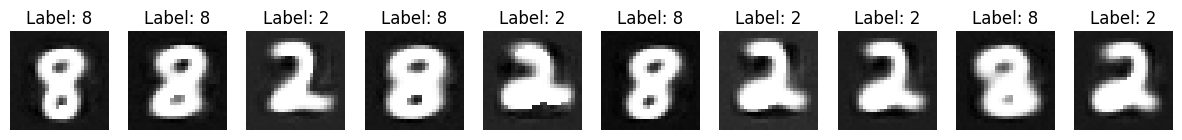

Task 2 | Epoch 0: Loss 0.046 Acc: 0.993
Task 2 | Epoch 1: Loss 0.011 Acc: 0.998
Task 2 | Epoch 0 | VAE loss: 0.6892377734184265
Task 2 | Epoch 1 | VAE loss: 0.6451992392539978
Task 2 | Epoch 2 | VAE loss: 0.634011447429657
Task 2 | Epoch 3 | VAE loss: 0.6037829518318176
Task 2 | Epoch 4 | VAE loss: 0.5961623787879944
Task 2 | Epoch 5 | VAE loss: 0.60406094789505
Task 2 | Epoch 6 | VAE loss: 0.5948746800422668
Task 2 | Epoch 7 | VAE loss: 0.5624487996101379
Task 2 | Epoch 8 | VAE loss: 0.5896437168121338
Task 2 | Epoch 9 | VAE loss: 0.5907848477363586
Task 2 | Epoch 10 | VAE loss: 0.5536707639694214
Task 2 | Epoch 11 | VAE loss: 0.5787397027015686
Task 2 | Epoch 12 | VAE loss: 0.5637559294700623
Task 2 | Epoch 13 | VAE loss: 0.5325705409049988
Task 2 | Epoch 14 | VAE loss: 0.5626675486564636


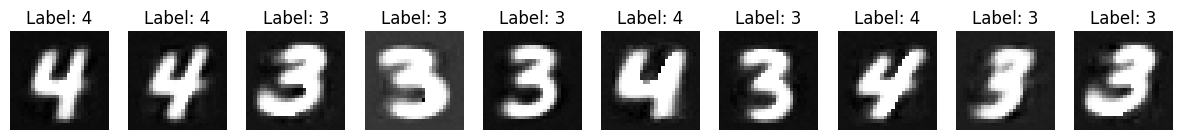

Task 3 | Epoch 0: Loss 0.024 Acc: 0.997
Task 3 | Epoch 1: Loss 0.005 Acc: 0.999
Task 3 | Epoch 0 | VAE loss: 0.697054922580719
Task 3 | Epoch 1 | VAE loss: 0.6802526712417603
Task 3 | Epoch 2 | VAE loss: 0.6548230051994324
Task 3 | Epoch 3 | VAE loss: 0.6264682412147522
Task 3 | Epoch 4 | VAE loss: 0.646216630935669
Task 3 | Epoch 5 | VAE loss: 0.59381103515625
Task 3 | Epoch 6 | VAE loss: 0.6166238784790039
Task 3 | Epoch 7 | VAE loss: 0.6274300813674927
Task 3 | Epoch 8 | VAE loss: 0.5961641669273376
Task 3 | Epoch 9 | VAE loss: 0.5808266401290894
Task 3 | Epoch 10 | VAE loss: 0.6009353399276733
Task 3 | Epoch 11 | VAE loss: 0.6142913699150085
Task 3 | Epoch 12 | VAE loss: 0.55213862657547
Task 3 | Epoch 13 | VAE loss: 0.5784896612167358
Task 3 | Epoch 14 | VAE loss: 0.5886811017990112


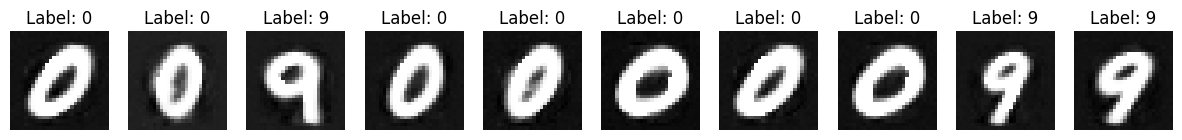

Task 4 | Epoch 0: Loss 0.019 Acc: 0.997
Task 4 | Epoch 1: Loss 0.007 Acc: 0.999
Task 4 | Epoch 0 | VAE loss: 0.6138482689857483
Task 4 | Epoch 1 | VAE loss: 0.6091006994247437
Task 4 | Epoch 2 | VAE loss: 0.5803712606430054
Task 4 | Epoch 3 | VAE loss: 0.5955736041069031
Task 4 | Epoch 4 | VAE loss: 0.5987245440483093
Task 4 | Epoch 5 | VAE loss: 0.5008646249771118
Task 4 | Epoch 6 | VAE loss: 0.5731825828552246
Task 4 | Epoch 7 | VAE loss: 0.5265717506408691
Task 4 | Epoch 8 | VAE loss: 0.49192172288894653
Task 4 | Epoch 9 | VAE loss: 0.5226426720619202
Task 4 | Epoch 10 | VAE loss: 0.47721436619758606
Task 4 | Epoch 11 | VAE loss: 0.5224766135215759
Task 4 | Epoch 12 | VAE loss: 0.5321229696273804
Task 4 | Epoch 13 | VAE loss: 0.5008606910705566
Task 4 | Epoch 14 | VAE loss: 0.5204159617424011


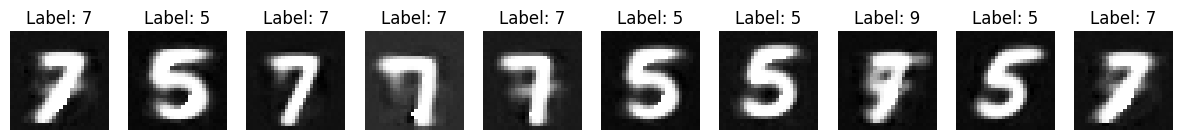

Memory usage (in bytes): [68180480, 146213888, 221846528, 298188800, 373134848]
Computation times (in seconds): [55.11540722846985, 52.8475558757782, 54.99676775932312, 54.149250745773315, 54.78772163391113]


In [78]:
# Set flag to train or load model
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = False

if load_model:
  # Load model
  infile = open(root_path + '/agent_VAE.pkl','rb')
  agent = pickle.load(infile)
  infile = open(root_path + '/random_model_acc_VAE.pkl','rb')
  random_model_acc = pickle.load(infile)

else:
  agent = Agent(args, train_tasks, val_tasks)
  agent.validate()
  random_model_acc = [i[0] for i in agent.acc.values()]
  agent.reset_acc()
  agent.train()

  #Save model
  with open(root_path + '/agent_VAE.pkl', 'wb') as pickfile:
      pickle.dump(agent, pickfile)
  with open(root_path + '/random_model_acc_VAE.pkl', 'wb') as pickfile:
    pickle.dump(random_model_acc, pickfile)

## Check performance results

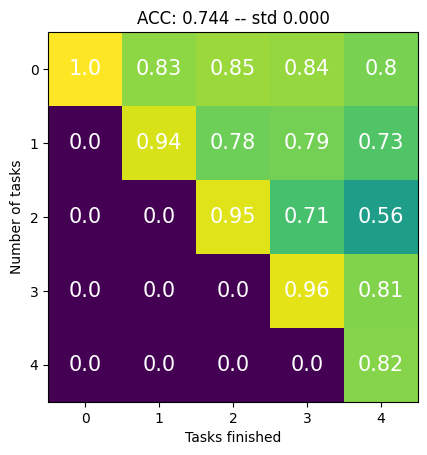

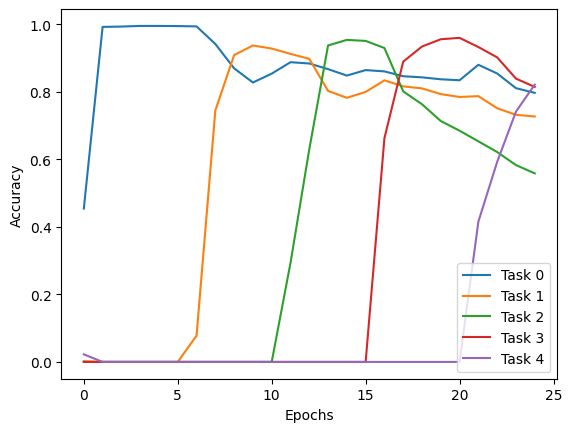

The average accuracy at the end of sequence is: 0.744
BWT:'-0.236'
FWT:'-0.074'


In [79]:
acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")

## Check time complexity and memory overhead

In [80]:
print(f"Memory usage for GAN replay (in GB): {np.sum(agent.memory_usage)/(1024 * 1024 * 1024):.3f}")
print(f"Memory usage for GAN replay (in minutes): {np.sum(agent.computation_times)/(60):.3f}")

# Metrics obtained from vanilla replay to compare (executed in another notebook)
memory_usage_greedy_bytes = [60875776, 135533568, 211653632, 290870272, 367564800]
computation_times_greedy_seconds = [21.074171543121338, 20.86911153793335, 27.85865879058838, 23.250384092330933, 24.339789867401123]
print("------------------------------------------------")
print(f"Memory usage for vanilla replay (in GB): {np.sum(memory_usage_greedy_bytes)/(1024 * 1024 * 1024):.3f}")
print(f"Memory usage for vanilla replay (in minutes): {np.sum(computation_times_greedy_seconds)/(60):.3f}")

Memory usage for GAN replay (in GB): 1.031
Memory usage for GAN replay (in minutes): 4.532
------------------------------------------------
Memory usage for vanilla replay (in GB): 0.993
Memory usage for vanilla replay (in minutes): 1.957
